In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from PIL import Image
from pprint import pprint

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input

from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 

In [3]:
class_df = pd.read_csv('../data/butterfly/CLASS NAMES.csv')
class_dict = pd.read_csv('../data/butterfly/class_dict.csv', index_col=0, squeeze=True).to_dict()

In [4]:
X = []
y = []
classes = list(class_dict['class'].values())
base_path = '../data/butterfly/train/'

SyntaxError: unexpected EOF while parsing (1895683605.py, line 1)

In [5]:
for i, target in enumerate(classes):
      files = os.listdir(base_path+target)
      for file in files:
         # loading the image
         img = Image.open(os.path.join(base_path,target,file))
         # convert it to an array
         img_array = np.array(img)
         # append the array to X
         X.append(img_array)
         # append the numeric target to y
         y.append(i)

In [6]:
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((9285, 224, 224, 3), (9285,))

In [25]:
y.shape

(9285,)

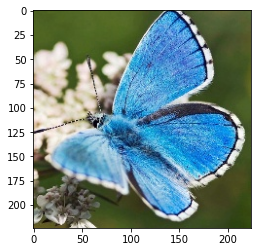

In [7]:
plt.imshow(X[55],cmap='gray')

# 2a Basic Model

In [8]:
X_pre = preprocess_input(X)

In [11]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

2022-02-10 12:25:31.701690: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 12:25:31.712393: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


2023424/2019640 [==============================] - 1s 0us/step


In [12]:
# freeze it!
base_model.trainable = False

In [14]:
len(classes)

75

In [15]:
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_224 (Model) (None, 1280)              410208    
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
Total params: 545,883
Trainable params: 135,675
Non-trainable params: 410,208
_________________________________________________________________


In [34]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
newy = enc.fit_transform([y]).todense()

matrix([[1., 1., 1., ..., 1., 1., 1.]])

In [40]:
newy = enc.fit_transform([y])

In [44]:
X.shape, y.shape

((9285, 224, 224, 3), (9285,))

In [43]:
newy

<1x9285 sparse matrix of type '<class 'numpy.float64'>'
	with 9285 stored elements in Compressed Sparse Row format>

In [1]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(X, y_binary, 
          epochs=10, 
          verbose=2,
          callbacks=[callback],
          # use 30% of the data for validation
          validation_split=0.3)

# OUTPUT FROM ABOVE:
# Train on 6499 samples, validate on 2786 samples
# Epoch 1/10
# 6499/6499 - 489s - loss: 2.7670 - categorical_accuracy: 0.3196 - val_loss: 9.7559 - val_categorical_accuracy: 0.0000e+00
# Epoch 2/10
# 6499/6499 - 413s - loss: 1.4320 - categorical_accuracy: 0.6069 - val_loss: 11.3448 - val_categorical_accuracy: 0.0000e+00
# Epoch 3/10

SyntaxError: invalid syntax (3345668683.py, line 14)

ValueError: You are passing a target array of shape (9285, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [47]:
from tensorflow.keras.utils import to_categorical

In [48]:
y_binary = to_categorical(y)

In [ ]:
pred = model.predict(X_pre)

In [ ]:
resnet_labels = decode_predictions(pred, top=5)
resnet_labels

# 3 Pretrained Model From Butteryfly Package

In [ ]:
from tensorflow.keras.models import load_model

# load, create and compile model



In [4]:
network = load_model("../data/butterfly/EfficientNetB3-butterflies-0.97.h5")
network.summary()

ValueError: Unknown layer: Functional

# 2. MobileNet and MobileNetV2

- This function returns a Keras image classification model, optionally loaded with weights pre-trained on ImageNet.

In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras import Model

In [14]:
# MobileNet block
def mobilnet_block (x, filters, strides):
    
    x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x

In [16]:
#stem of the model
input = Input(shape = (224,224,3))
x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

2022-02-09 21:27:47.027616: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-09 21:27:47.047347: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


In [1]:
# main part of the model
x = mobilnet_block(x, filters = 64, strides = 1)
x = mobilnet_block(x, filters = 128, strides = 2)
x = mobilnet_block(x, filters = 128, strides = 1)
x = mobilnet_block(x, filters = 256, strides = 2)
x = mobilnet_block(x, filters = 256, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 2)
for _ in range (5):
     x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 1024, strides = 2)
x = mobilnet_block(x, filters = 1024, strides = 1)
x = AvgPool2D (pool_size = 7, strides = 1, data_format='channels_first')(x)
output = Dense (units = 1000, activation = 'softmax')(x)
model = Model(inputs=input, outputs=output)
model.summary()

NameError: name 'mobilnet_block' is not defined

In [20]:
#plot the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
